## Load Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import plot_roc_curve, roc_auc_score

## Load Data

In [2]:
pre_data = pd.read_csv('COVID_host_classifier_all_genes.txt', sep = '\t').T
pre_data.columns = pre_data.iloc[0]
pre_data = pre_data.drop('Unnamed: 0')
pre_data['Class'] = [item[0] for item in np.char.split(pre_data.index.values.astype(str), '.')] 
pre_data['Experiment'] = 'Primary'


## Make ROC Curves

In [3]:
def plot_curve(comp, genes):
    
    # Determines the appropriate values for X and y:
    # 'nv' compares COVID against No-Virus
    # 'ov' compares COVID against Other-Virus
    # 'nvov' compares No-Virus against Other-Virus
    # 'cvno' compares COVID against No-Virus and Other-Virus
    # 'ovnc' compares Other-Virus against No-Virus and COVID
    
    data = pre_data[['Class', 'Experiment'] + genes].dropna(axis = 0, subset = genes)
    
    if comp == 'nv':
        filt = data[(data['Experiment'] == 'Primary') & ((data['Class'] == 'COVID-19') | (data['Class'] == 'No-Virus'))]
        X = filt[genes].values
        y = (filt['Class'] == 'COVID-19').values
        label = 'COVID+ vs. COVID-'
    elif comp == 'ov':
        filt = data[(data['Experiment'] == 'Primary') & ((data['Class'] == 'COVID-19') | (data['Class'] == 'Other-Virus'))]
        X = filt[genes].values
        y = (filt['Class'] == 'COVID-19').values
        label = 'COVID+ vs. Other-Virus'
    elif comp == 'nvov':
        filt = data[(data['Experiment'] == 'Primary') & ((data['Class'] == 'No-Virus') | (data['Class'] == 'Other-Virus'))]
        X = filt[genes].values
        y = (filt['Class'] == 'No-Virus').values
        label = 'COVID- vs. Other-Virus'
    elif comp == 'cvno':
        filt = data[(data['Experiment'] == 'Primary')]
        X = filt[genes].values
        y = (filt['Class'] == 'COVID-19').values
        label = 'COVID+ vs. COVID- + Other-Virus'
    elif comp == 'ovnc':
        filt = data[(data['Experiment'] == 'Primary')]
        X = filt[genes].values
        y = (filt['Class'] == 'Other-Virus').values
        label = 'Other-Virus vs. COVID- + COVID+'
    else:
        return 0
    
    cv = StratifiedKFold(n_splits=5)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    seed = 8675309
    
    fig, ax = plt.subplots(figsize=(6, 6))
    cv_scores = np.zeros(len(y))
    for i, (train, test) in enumerate(cv.split(X, y)):
        
        scaler = StandardScaler()
        scaler.fit(X[train])
        X_sc = scaler.transform(X)
        classifier = SVC(kernel='linear', probability=True, random_state=seed)
        classifier.fit(X_sc[train], y[train])
        clf_scores = classifier.predict_proba(X_sc[test])[:, 1]
        cv_scores[test] = clf_scores
        viz = plot_roc_curve(classifier, X_sc[test], y[test], name='ROC fold {}'.format(i), alpha=0.3, lw=1, ax=ax)
        viz.line_.remove()
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
    
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
    
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b', label=r'ROC (AUC = %0.3f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=.8)
    
    
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')
    
    
    
    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title='%s and %s, %s' % (genes[0], genes[1], label))
    ax.legend(loc="lower right")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    #plt.show()
    
    
    # Uncomment to save figures and scores to files
    
    plt.savefig('%s (%s+%s).pdf' % (label, genes[0], genes[1]), dpi = 200)
    #np.savetxt('%s (%s+%s).txt' % (label, genes[0], genes[1]), cv_scores)

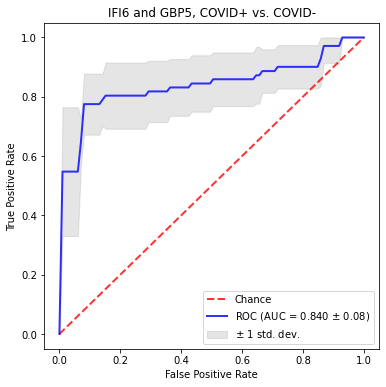

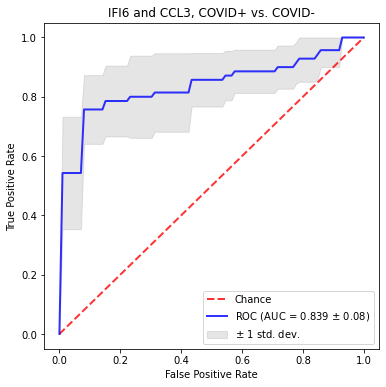

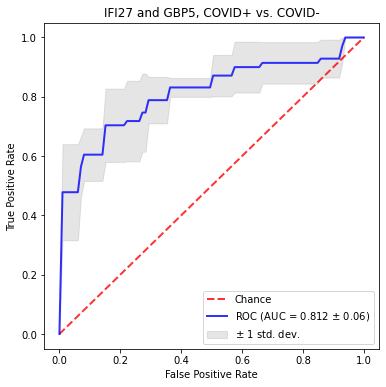

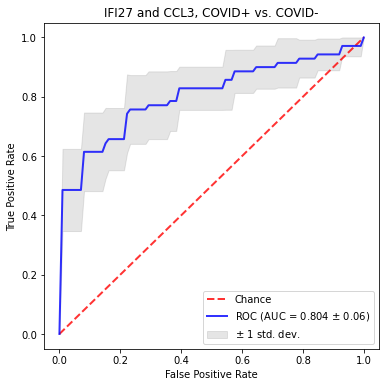

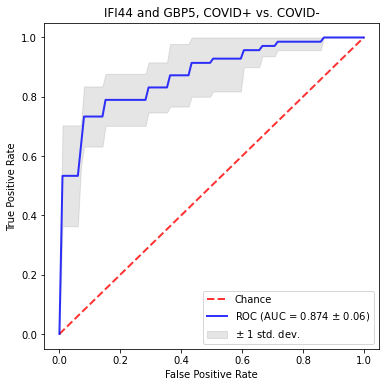

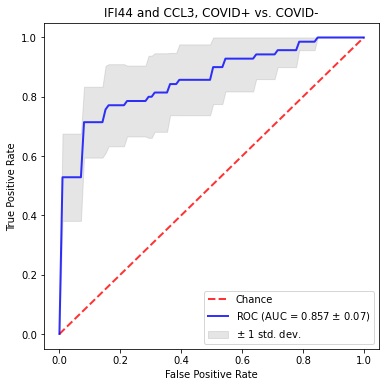

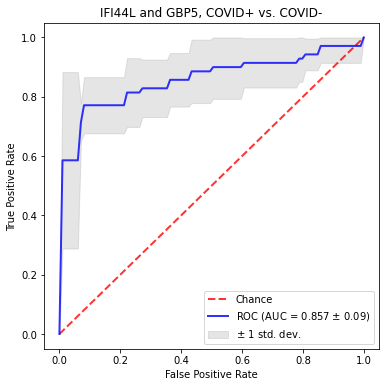

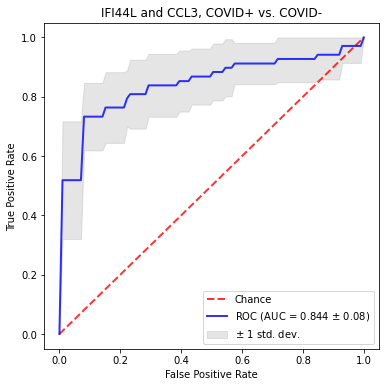

In [4]:
for one in ['IFI6', 'IFI27', 'IFI44', 'IFI44L']:
    for two in ['GBP5', 'CCL3']:
        plot_curve('nv', [one, two])

In [5]:
def plot_curve_1g(comp, gene):
    
    # Determines the appropriate values for X and y:
    # 'nv' compares COVID against No-Virus
    # 'ov' compares COVID against Other-Virus
    # 'nvov' compares No-Virus against Other-Virus
    # 'cvno' compares COVID against No-Virus and Other-Virus
    # 'ovnc' compares Other-Virus against No-Virus and COVID
    
    data = pre_data[['Class', 'Experiment'] + gene].dropna(axis = 0, subset = gene)
    
    if comp == 'nv':
        filt = data[(data['Experiment'] == 'Primary') & ((data['Class'] == 'COVID-19') | (data['Class'] == 'No-Virus'))]
        X = filt[gene].values
        y = (filt['Class'] == 'COVID-19').values
        label = 'COVID+ vs. COVID-'
    elif comp == 'ov':
        filt = data[(data['Experiment'] == 'Primary') & ((data['Class'] == 'COVID-19') | (data['Class'] == 'Other-Virus'))]
        X = filt[gene].values
        y = (filt['Class'] == 'COVID-19').values
        label = 'COVID+ vs. Other-Virus'
    elif comp == 'nvov':
        filt = data[(data['Experiment'] == 'Primary') & ((data['Class'] == 'No-Virus') | (data['Class'] == 'Other-Virus'))]
        X = filt[gene].values
        y = (filt['Class'] == 'No-Virus').values
        label = 'COVID- vs. Other-Virus'
    elif comp == 'cvno':
        filt = data[(data['Experiment'] == 'Primary')]
        X = filt[gene].values
        y = (filt['Class'] == 'COVID-19').values
        label = 'COVID+ vs. COVID- + Other-Virus'
    elif comp == 'ovnc':
        filt = data[(data['Experiment'] == 'Primary')]
        X = filt[gene].values
        y = (filt['Class'] == 'Other-Virus').values
        label = 'Other-Virus vs. COVID- + COVID+'
    else:
        return 0
    
    cv = StratifiedKFold(n_splits=5)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    seed = 8675309
    
    fig, ax = plt.subplots(figsize=(6, 6))
    cv_scores = np.zeros(len(y))
    for i, (train, test) in enumerate(cv.split(X, y)):
        
        scaler = StandardScaler()
        scaler.fit(X[train])
        X_sc = scaler.transform(X)
        classifier = SVC(kernel='linear', probability=True, random_state=seed)
        classifier.fit(X_sc[train], y[train])
        clf_scores = classifier.predict_proba(X_sc[test])[:, 1]
        cv_scores[test] = clf_scores
        viz = plot_roc_curve(classifier, X_sc[test], y[test], name='ROC fold {}'.format(i), alpha=0.3, lw=1, ax=ax)
        viz.line_.remove()
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
    
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
    
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b', label=r'ROC (AUC = %0.3f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=.8)
    
    
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')
    
    
    
    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title='%s, %s' % (gene[0], label))
    ax.legend(loc="lower right")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    #plt.show()
    
    
    # Uncomment to save figures and scores to files
    
    plt.savefig('%s (%s).pdf' % (label, gene[0]), dpi = 200)
    #np.savetxt('%s (%s).txt' % (label, gene[0]), cv_scores)

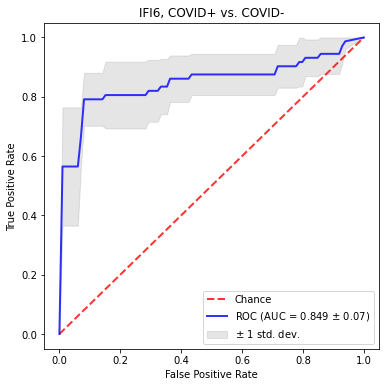

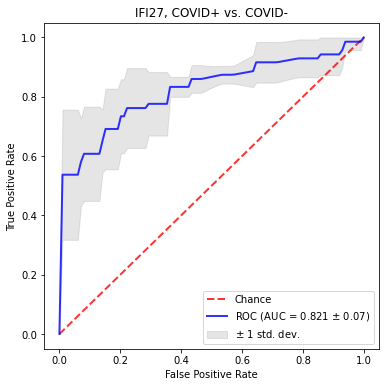

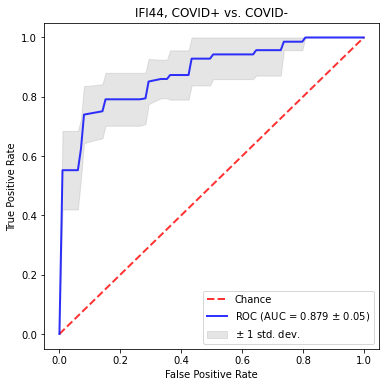

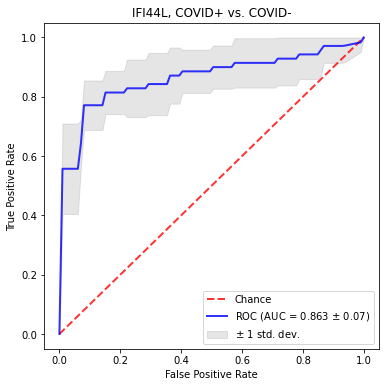

In [6]:
for one in ['IFI6', 'IFI27', 'IFI44', 'IFI44L']:
    plot_curve_1g('nv', [one])

## Apply Models to Variants and Spike-ins

In [7]:
acc_data = pd.read_csv('PCR_delta_delta_host_classifier_COVIDvariants_FalsePos_10.7.21.txt', sep = '\t')

In [8]:
bad_samples = []
for acc in ['W25567', 'T30769', 'T27678', 'T31678', 'T31653', 'W26168', 'W22139', 'T30193', 'T31344', 'T31403', 'T29842', 'T31366', 'T32483', 'T32619', 'T32573']:
    bad_samples.append(acc_data[(acc_data['Experiment'] == 'Primary') & (acc_data['Accession'] == acc)].index[0])


In [9]:
data = pd.read_csv('PCR_delta_delta_host_classifier_COVIDvariants_FalsePos_9.7.21.txt', sep = '\t')
data.index = data['Sample_ID']
data = data[['Class', 'COVID-variant', 'Experiment', 'IFI6', 'GBP5']].dropna(axis = 0, subset = ['IFI6', 'GBP5'])
data = data.drop(data.index[bad_samples])

In [10]:
# Uses the same CV loop and models generated by plot_curve to get COVID probability estimates for additional expression data.

def external_data(comp, ext):
    
    if comp == 'nv':
        filt = data[(data['Experiment'] == 'Primary') & ((data['Class'] == 'COVID-19') | (data['Class'] == 'No-Virus'))]
        X = filt[['IFI6', 'GBP5']].values
        y = (filt['Class'] == 'COVID-19').values
        label = 'COVID vs. No-Virus'
    elif comp == 'ov':
        filt = data[(data['Experiment'] == 'Primary') & ((data['Class'] == 'COVID-19') | (data['Class'] == 'Other-Virus'))]
        X = filt[['IFI6', 'GBP5']].values
        y = (filt['Class'] == 'COVID-19').values
        label = 'COVID vs. Other-Virus'
    elif comp == 'nvov':
        filt = data[(data['Experiment'] == 'Primary') & ((data['Class'] == 'No-Virus') | (data['Class'] == 'Other-Virus'))]
        X = filt[['IFI6', 'GBP5']].values
        y = (filt['Class'] == 'No-Virus').values
        label = 'No-Virus vs. Other-Virus'
    elif comp == 'cvno':
        filt = data[(data['Experiment'] == 'Primary')]
        X = filt[['IFI6', 'GBP5']].values
        y = (filt['Class'] == 'COVID-19').values
        label = 'COVID vs. No-Virus + Other-Virus'
    elif comp == 'ovnc':
        filt = data[(data['Experiment'] == 'Primary')]
        X = filt[['IFI6', 'GBP5']].values
        y = (filt['Class'] == 'Other-Virus').values
        label = 'Other-Virus vs. No-Virus + COVID'
    else:
        return 0
    
    
    
    cv = StratifiedKFold(n_splits=5)
    seed = 8675309
    ext_all_scores = []
    for i, (train, test) in enumerate(cv.split(X, y)):
        
        scaler = StandardScaler()
        scaler.fit(X[train])
        
        X_sc = scaler.transform(X)
        X_ext = scaler.transform(ext)
        
        classifier = SVC(kernel='linear', probability=True, random_state=seed)
        classifier.fit(X_sc[train], y[train])
        
        ext_scores = classifier.predict_proba(X_ext)[:, 1]
        ext_all_scores.append(ext_scores)
        
    return np.average(ext_all_scores, axis = 0)

In [11]:
ext_data = data[data['Experiment'] != 'Primary']

In [12]:
ext_out = ext_data[['Class', 'COVID-variant', 'Experiment']].copy()
ext_out['COVID Probability'] = external_data('nv', ext_data[['IFI6', 'GBP5']])
ext_out.to_csv('COVID_Probability_Table.csv')